In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm


from pseudobatch import pseudobatch_transform_pandas_by_group
from pseudobatch.datasets import load_real_world_yeast_fedbatch 


/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'stan_version_major': '2', 'stan_version_minor': '29', 'stan_version_patch': '2', 'STAN_THREADS': 'false', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}


This data is from a cultivation experiment done in a Biolector (actually a Robolector) operating in fed-batch mode. Four different __S. cerevisiae__ strains were cultivated in 8 replicates, there only difference is when the individual culture was sampled and how many times samples were drawn. Thus the dataset contains a total of 32 growth curves. In this tutorial we will show how to use pseudobatch transformation to transform all 32 growth curves and how to estimate the growth rate for each replicate.

The Biolector is capable of collect online biomass measurements through the light scatter sensor. Thus this dataset contains a biomass measurement for each approximately fifth minute.

First, we will load the dataset which is a part of the `pseudobatch.datasets`, thus is is easily loaded.

In [2]:
fedbatch_df = load_real_world_yeast_fedbatch()
fedbatch_df.head()

,Strain,Biolector well,Biolector column,Biolector row,Cycle,Time,Feeding time,Volume,Accum. feed [uL],Biomass concentration [light scatter],DO%,Sample volume
0,Yeast_strain_1,C01,1,C,145.0,14.5028,0.2,800.32,0.32,2.89,147.440002,0.0
1,Yeast_strain_1,C02,2,C,145.0,14.5028,0.2,800.32,0.32,2.84,146.250000,0.0
2,Yeast_strain_2,C03,3,C,145.0,14.5028,0.2,800.32,0.32,2.93,145.429993,0.0
3,Yeast_strain_2,C04,4,C,145.0,14.5028,0.2,800.32,0.32,2.97,145.610001,0.0
4,Yeast_strain_3,C05,5,C,145.0,14.5028,0.2,800.32,0.32,3.13,148.240005,0.0


This dataset is preprocessed into a format that is very similar to the format of the simulated datasets used in the previous tutorials. This format follows the "Tidy"-format also called "long-format". Each row represent measurements of one culture at one time point. For example row 0 above hold the biomass, Volume, and Accumulated feed measurements etc of Biolector well C01 at feeding time 0.2 hours (time relative to feed initiation).

To get lets have look at the growth curves (light scatter measurements).

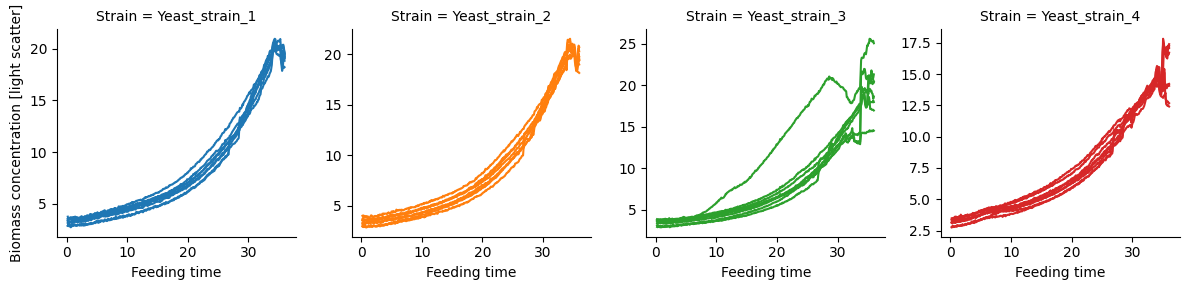

In [3]:
# plotting
g = sns.FacetGrid(fedbatch_df, col="Strain", hue="Strain", sharey=False)
g.map_dataframe(sns.lineplot, data=fedbatch_df, x='Feeding time', y='Biomass concentration [light scatter]', units="Biolector well", estimator=None)

Thus to make an overall estimate of the growth rates for each culture we will need use the pseudobatch transformation. We need to apply the pseudobatch transformation to each culture (Biolector well). We provide a wrapper function that groups a dataframe by some column(s) and apply the pseudobatch transformation to each group. This function is very useful in situations like this.

In [11]:
biomass_concentration_in_feed = 0 # There is no yeast cells in the feed medium

# Apply pseudobatch transformation and save the transformed biomass concentration in a new column
fedbatch_df[["Biomass pseudo concentration"]] = pseudobatch_transform_pandas_by_group(
    fedbatch_df,
    groupby_cols=["Biolector well"], # we want to apply the pseudobatch transformation to each culture (Biolector well)
    measured_concentration_colnames=["Biomass concentration [light scatter]"], # we wish to transform the biomass concentration measurements
    reactor_volume_colname='Volume',
    accumulated_feed_colname='Accum. feed [uL]',
    concentration_in_feed=[biomass_concentration_in_feed],
    sample_volume_colname='Sample volume',
)

Now that we have transformed the data we fit a log-linear model to each of the growth curve. Similar to previous tutorials we define a small helper function to fit the model.

In [12]:
def fit_ols_model(formula_like: str, data: pd.DataFrame) -> sm.regression.linear_model.RegressionResultsWrapper:
    y, X = dmatrices(formula_like, data)
    model = sm.OLS(endog=y, exog=X)
    res = model.fit()
    return res

We can now iterate through the data from Biolector well and estimate the growth rate.

In [16]:
growth_rate_models = {}
for grp, dat in fedbatch_df.groupby(['Strain', 'Biolector well']):
    growth_rate_models[grp] = fit_ols_model('np.log(Q("Biomass pseudo concentration")) ~ Q("Feeding time")', dat)

# collect the growth rates in a dataframe
growth_rates_df = pd.DataFrame(
    [
        [strain, well, mod.params[1]] for (strain, well), mod in growth_rate_models.items()
    ], 
    columns=['Strain', 'Biolector well', 'Growth rate']
)

Finally, we can inspect estimated growth rates for each of cultures.

([0, 1, 2, 3],
 [Text(0, 0, 'Yeast_strain_1'),
  Text(1, 0, 'Yeast_strain_2'),
  Text(2, 0, 'Yeast_strain_3'),
  Text(3, 0, 'Yeast_strain_4')])

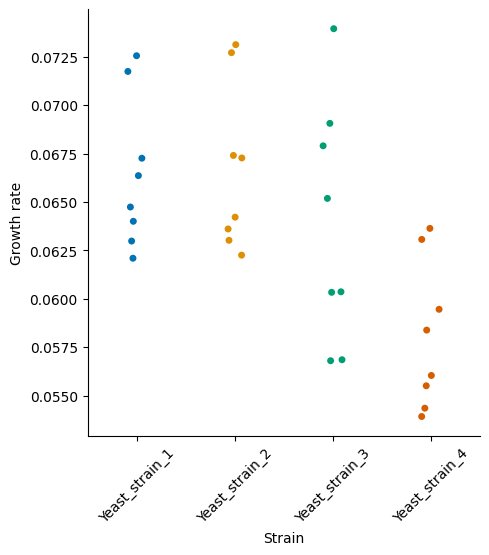

In [17]:
sns.catplot(data=growth_rates_df, x='Strain', y='Growth rate', hue='Strain', palette='colorblind')
plt.xticks(rotation=45)

We can see that strains 1, 2, and 3 have similar growth rates, while strain 4 appears to grow a little slower. In this example we showed how to use the pseudobatch transformation to transform real world data.